In [1]:
lapply(c("dplyr", "DBI", "stringr", "ggplot2"),
library, character.only = TRUE)



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




[[1]]
[1] "dplyr"     "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[2]]
[1] "DBI"       "dplyr"     "stats"     "graphics"  "grDevices" "utils"    
[7] "datasets"  "methods"   "base"     

[[3]]
 [1] "stringr"   "DBI"       "dplyr"     "stats"     "graphics"  "grDevices"
 [7] "utils"     "datasets"  "methods"   "base"     

[[4]]
 [1] "ggplot2"   "stringr"   "DBI"       "dplyr"     "stats"     "graphics" 
 [7] "grDevices" "utils"     "datasets"  "methods"   "base"

In [2]:
### getting database connection, fetching tables ###

getDBConnection <- function() {
    # returns a connection object to fetch db tables 

    conn <- DBI::dbConnect(RPostgres::Postgres(), dbname = 
        "fred", host = Sys.getenv("PGHOST"), port = 
        Sys.getenv("PGPORT"), user = Sys.getenv("PGUSER"), 
        password = Sys.getenv("PGPW"))
    return (conn)
}

fetchTable <- function(table_name) {
    # uses connection object to fetch and return tables stored in db 

    if (str_detect(table_name, " ")) {
        stop("Table name does not include whitespace")
        return (1) # exit code 1 on exception 
    }
    conn <- getDBConnection()
    query <- conn %>% DBI::dbSendQuery(
            paste("select * from ", table_name))
    data <- query %>% DBI::dbFetch() %>% as_tibble()
    query %>% DBI::dbClearResult()
    conn %>% DBI::dbDisconnect()
    return (data)
}


In [3]:
gdp <- fetchTable("real_gross_domestic_product")
home_price_idx <- "s_p_case_shiller_u_s__national_home_price_index" %>% 
    fetchTable()
reit <- "wilshire_us_real_estate_investment_trust_total_market_index__wi" %>% 
    fetchTable()
total_public_debt <- fetchTable("federal_debt__total_public_debt")
sahm <- fetchTable("real_time_sahm_rule_recession_indicator")
total_reserves <- "total_reserves_excluding_gold_for_united_states" %>%
    fetchTable()


In [4]:
### cleaning ###

# changes only inconvenient column names
gdp <- gdp %>% rename(pct_ch_gdp = a191rl1q225sbea)
home_price_idx <- home_price_idx %>% rename(hp_index = csushpisa)
total_reserves <- total_reserves %>% rename(tot_res = tresegusm052n)


In [6]:
# drops NA and extra id column
sahm <- sahm %>% select(date_of_obs, sahmrealtime)
home_price_idx <- home_price_idx %>% filter(!is.na(hp_index)) %>%
    select(date_of_obs, hp_index)
gdp <- gdp %>% select(date_of_obs, pct_ch_gdp)
total_public_debt <- total_public_debt %>% 
    select(date_of_obs, gfdebtn)
total_reserves <- total_reserves %>% filter(!is.na(tot_res)) %>%
    select(date_of_obs, tot_res)
reit <- reit %>% filter(!is.na(willreitind)) %>%
    select(date_of_obs, willreitind)

# undifferenced version is assigned series w/o first-difference
# these redundant tibbles are stored only as backups 
home_price_idx_ud <- home_price_idx
total_public_debt_ud <- total_public_debt
total_reserves_ud <- total_reserves
reit_ud <- reit


In [7]:
getDifferencedSeries <- function(df, col_string) {
    # returns series' change from preceding period

    differenced <- df %>% select(all_of(col_string)) %>% 
                as.matrix() %>% diff() %>% as.vector()
    return (differenced)
}

setDifferencedTibble <- function(df, diff_vector, col_string) {
    # retains undifferenced series and adds differenced version

    new_df <- df[-1, ] %>% 
        # adds differenced series 
        mutate(series_1d = diff_vector) %>% 
        # reorders columns
        select(date_of_obs, series_1d, all_of(col_string))
    return (new_df)
}

# includes rename of generic series_1d
# renaming the first-differenced series within the 
# setDifferenceTable() method isn't feasible
home_price_idx <- home_price_idx %>% getDifferencedSeries("hp_index") %>% 
    setDifferencedTibble(df = home_price_idx, col_string = "hp_index") %>%
    rename(hp_index_1d = series_1d)
total_public_debt <- total_public_debt %>% getDifferencedSeries("gfdebtn") %>% 
    setDifferencedTibble(df = total_public_debt, col_string = "gfdebtn") %>%
    rename(gfdebtn_1d = series_1d)
total_reserves <- total_reserves %>% getDifferencedSeries("tot_res") %>% 
    setDifferencedTibble(df = total_reserves, col_string = "tot_res") %>%
    rename(tot_res_1d = series_1d)
reit <- reit %>% getDifferencedSeries("willreitind") %>% 
    setDifferencedTibble(df = reit, col_string = "willreitind") %>% 
    rename(willreitind_1d = series_1d)


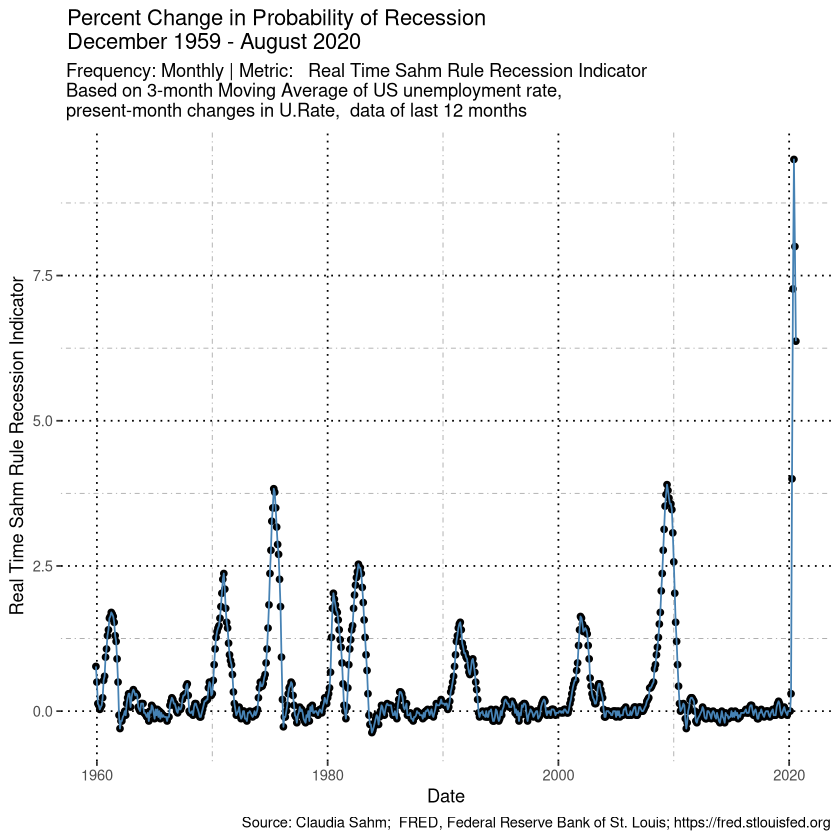

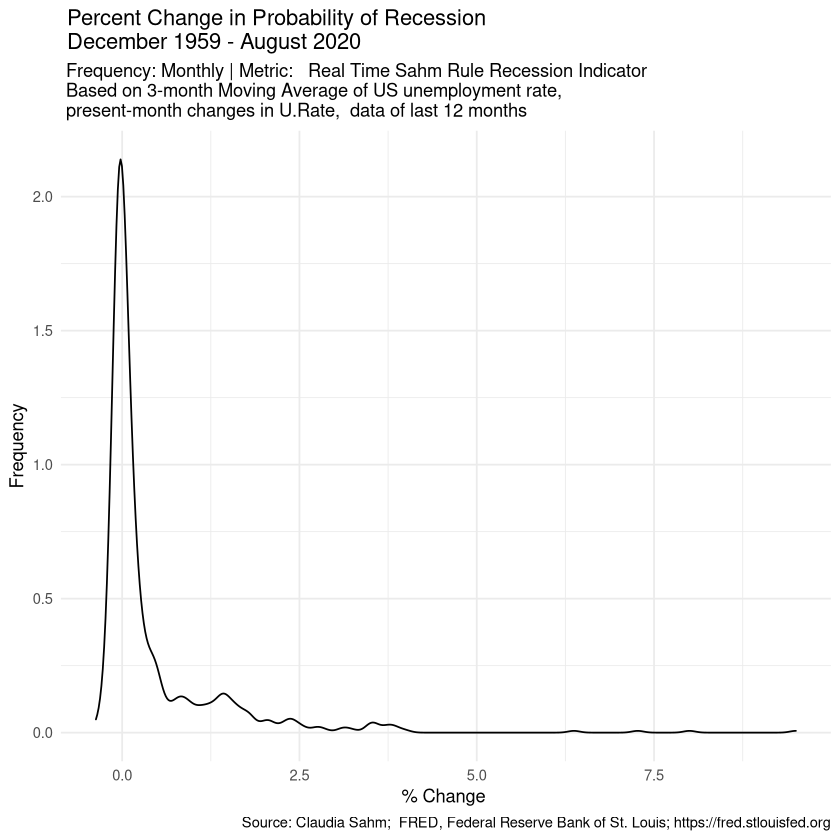

In [8]:

sahm_table_name <-  " Real Time Sahm Rule Recession Indicator "
sahm_title <- paste(" Percent Change in Probability of Recession ", 
    "\n December 1959 - August 2020") 
sahm_subtitle <- paste(" Frequency: Monthly | Metric: ",
    sahm_table_name, "\n Based on 3-month Moving Average of US unemployment rate,",  
    "\n", "present-month changes in U.Rate,", " data of last 12 months")
caption_all <- paste("FRED, Federal Reserve Bank of St. Louis;", 
     "https://fred.stlouisfed.org")
sahm_caption <- paste("Source: Claudia Sahm; ", caption_all)

ggplot(sahm) + 
aes(x = date_of_obs, y = sahmrealtime) + 
geom_point() + geom_line(color = "steelblue") + 
labs(title = sahm_title, 
subtitle = sahm_subtitle, x = "Date",
y = sahm_table_name, caption = sahm_caption) + 
theme(panel.background = element_blank()) + 
theme(panel.grid.major = element_line(color = "black", 
linetype = 3)) + theme(panel.grid.minor = 
element_line(color = "darkgrey", linetype = 4))

ggplot(sahm) + aes(sahmrealtime) +
geom_density(kernel = "gaussian") +
labs(title = sahm_title, subtitle = sahm_subtitle, 
x = "% Change ", y = "Frequency", caption = sahm_caption) + 
theme_minimal()
